<a href="https://colab.research.google.com/github/lialic/Neural-network-and-Genetic-algorithm/blob/master/ES_DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the necessary libraries

In [3]:
import numpy as np
from numpy import meshgrid
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import distance
import os
import pandas as pd

## Mounting drive for easier storing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/Data/ES_DE')

# Then, we introduce all of the function that we want to maximize it

In [6]:
def Rastrigin_Function(x):
    if isinstance(x, (list, tuple)):
        x = np.array(x)

    return 10 * x.shape[0] + np.sum(x**2 - 10 * np.cos(2* np.pi * x))

def Ackley_Function(x):
    if isinstance(x, (list, tuple)):
        x = np.array(x)

    p1 = -0.2 * np.sqrt(0.5 * np.sum(x**2))
    p2 = 0.5 * np.sum(np.cos(np.pi*x))

    return -20 * np.exp(p1) - np.exp(p2) + np.e + 20

def RosenBrock_Function(x):
    if isinstance(x, (list, tuple)):
        x = np.array(x)

    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2) 

def Sphere_Function(x):
    if isinstance(x, (list, tuple)):
        x = np.array(x)

    return np.sum(x**2)

def Griewank_Function(x):
    if isinstance(x, (list, tuple)):
        x = np.array(x)

    sum, prod = 0, 1
    for i in range(len(x)):
        sum += x[i] * x[i] / 4000
        prod *= np.cos(x[i] / np.sqrt(i + 1))

    return sum - prod + 1

In [7]:
Rastrigin = {
    'search_domain': (-5.12, 5.12),
    'formula': Rastrigin_Function,
    'global_minimum': 0,
    'name': 'Rastrigin'
}

Ackley = {
    'search_domain': (-5, 5),
    'formula': Ackley_Function,
    'global_minimum': 0,
    'name': 'Ackley'
}

RosenBrock = {
    'search_domain': (-128, 128),
    'formula': RosenBrock_Function,
    'global_minimum': 0,
    'name': 'RosenBrock'
}   

Sphere = {
    'search_domain': (-np.inf, np.inf),
    'formula': Sphere_Function,
    'global_minimum': 0,
    'name': 'Sphere'
}
Griewank = {
    'search_domain': (-600, 600),
    'formula': Griewank_Function,
    'global_minimum': 0,
    'name': 'Griewank'
}

# (1+$\lambda$) ES

In [ ]:
def OneLambdaES(dims, lam=2, optimizer=Sphere, m_init=None, sigma_init=1, max_iters=1000, c_INC=1.1, c_DEC=0.6, seed=None, save_data=True, max_eva=5000000):
    
    np.random.seed(seed)

    dom = optimizer['search_domain']
    F = optimizer['formula']
    global_minimum = optimizer['global_minimum'] * np.ones(dims)

    sigma = sigma_init

    # Init the first random position
    if m_init is None:
        if (dom[0] != -np.inf) and (dom[1] != np.inf):
            m = np.random.rand(dims) * (dom[1] - dom[0]) + dom[0]

        elif (dom[0] == -np.inf) and (dom[1] == np.inf):
            m = np.random.rand(dims)
        
        elif (dom[0] != -np.inf):
            m = np.random.rand(dims) + dom[0]

        else:
            m = np.random.rand(dims) - (dom[1] + 1)

    else:
        m = m_init

    m_history = []
    offspring_history = []
    sigma_history = []
    success_history = []
    Fm_history = []
    dist2global = []
    idbest_history = []
    number_of_evaluations = 0
    eva_history = []

    while True:

        m_history.append(m)

        #Save the distance between current m and global minimum
        dist = distance.euclidean(m, global_minimum)
        dist2global.append(dist)

        sigma_history.append(sigma)

        # We want to create an \epsilon vector that lies in the range of
            #standard distribution that have mean = 0 and std = 1
        # Create perb (perbutation) that lies inside (0,1)
        perb = np.random.randn(lam, dims) #epsilon ~ N(0,1)

        #Create offspring x = m + sigma*perb
            # It's quite the same thing with gradient descent as sigma have similar feature to learning rate
        x = m + sigma*perb

        #If x is out of our search range then update it back
        x = np.clip(x, dom[0], dom[1])

        offspring_history.append(x)

        #(1 + 1) selection
        F_m = F(m)
        number_of_evaluations += 1

        #Find x_best in all of offspring
        F_off = np.array([F(x[i]) for i in range(lam)])
        number_of_evaluations += lam

        id_best = F_off.argmin()
        Fx_best = F_off[id_best]
        x_best = x[id_best]

        Fm_history.append(F_m)
        idbest_history.append(id_best)
        eva_history.append(number_of_evaluations)

        if Fx_best <= F_m: #If parent is not as fit as offspring
            m = x_best.copy() # Then use offspring as the new parent

            # Increase sigma as we know that we still can discover
                # To open up the circle range
            sigma *= c_INC 
            
            success_history.append(1)
        else: 
            # Lower the range as we can not find the one that is better
            sigma *= c_DEC
            success_history.append(0)

        if number_of_evaluations >= max_eva or Fx_best == 0:
            break
    # The combination of randomness and judgement in each step 
        # is ~ gradient

    x_opt = m
    F_opt = F(x_opt)
    number_of_evaluations += 1

    m_history.append(x_opt)
    Fm_history.append(F_opt)
    dist2global.append(distance.euclidean(x_opt, global_minimum))
    sigma_history.append(sigma)

    opt_name = optimizer['name']
    if save_data:
        np.savez(f'./statistics/{opt_name}_{dims}_{lam}_{seed}_OneLambdaES.npz', m=m_history, Fm=Fm_history \
                 , offspring=offspring_history, sigma=sigma_history, success=success_history \
                 , dist=dist2global, evaluations=eva_history, idbest=idbest_history)
        
    return F_opt, x_opt, number_of_evaluations



## Actual running

In [ ]:
d = [2, 10]
N = [32, 64, 128, 256, 512, 1024]
f = [Sphere, Rastrigin, RosenBrock, Griewank, Ackley]
seed = np.arange(19520208, 19520208+10)
repeat = [100000, 1000000]

In [ ]:
for func in f:
    for var in d:
        nameF = func['name']
        file_name = f'./tables/{nameF}_{var}'
        df = pd.read_pickle(file_name)

        Tmean_F = []
        Tstd_F = []

        Tmean_x = []
        Tstd_x = []

        Tmean_eva = []
        Tstd_eva = []

        for pop_size in N:
            if var == 2:
                max_eva = repeat[0]
            else:
                max_eva = repeat[1]

            print(f'{nameF}, {var}, {pop_size}')
            lF = []
            lx = []
            leva = []

            for i in seed:
                
                F_opt, x_opt, number_of_evaluations = OneLambdaES(var, pop_size, func \
                                                                , seed=i, max_eva = max_eva)
                lF.append(F_opt)
                lx.append(x_opt)
                leva.append(number_of_evaluations)

            mean_F = np.mean(lF)
            std_F = np.std(lF)
            mean_x = np.mean(lx)
            std_x = np.std(lx)
            mean_eva = np.mean(leva)
            std_eva = np.std(leva)

            Tmean_F.append(mean_F)
            Tstd_F.append(std_F)

            Tmean_x.append(mean_x)
            Tstd_x.append(std_x) 

            Tmean_eva.append(mean_eva)
            Tstd_eva.append(std_eva)

        df['ES', 'mean(F)'] = Tmean_F
        df['ES', 'std(F)'] = Tstd_F
        df['ES', 'mean(x)'] = Tmean_x          
        df['ES', 'std(x)'] = Tstd_x
        df['ES', 'mean(eva)'] = Tmean_eva
        df['ES', 'std(eva)'] = Tstd_eva

        df.to_pickle(file_name)


# DE

In [ ]:
def DE(dims, popsize, optimizer=Sphere, m_init=None, F_scale=0.8, cross_prob=0.7, seed=None, save_data=True, max_eva=5000000):
    np.random.seed(seed)

    dom = optimizer['search_domain']
    F = optimizer['formula']
    global_minimum = optimizer['global_minimum'] * np.ones(dims)


    # Init the first random position
    if m_init is None:
        if (dom[0] != -np.inf) and (dom[1] != np.inf):
            m = np.random.rand(popsize, dims) * (dom[1] - dom[0]) + dom[0]

        elif (dom[0] == -np.inf) and (dom[1] == np.inf):
            m = np.random.rand(popsize, dims)
        
        elif (dom[0] != -np.inf):
            m = np.random.rand(popsize, dims) + dom[0]

        else:
            m = np.random.rand(popsize, dims) - (dom[1] + 1)

    else:
        m = m_init

    m_history = []
    offspring_history = []
    success_history = []
    Fm_history = []
    idbest_history = []
    eva_history = []
    number_of_evaluations = 0
    results = []

    # Judge the first ever population
    m_history.append(np.copy(m))

    F_m = np.array([F(ind) for ind in m])
    Fm_history.append(np.copy(F_m))
    number_of_evaluations += popsize

    # Find the best one at the time
    id_best = np.argmin(F_m)  
    Fx_best = F_m[id_best]
    x_best = m[id_best]

    results.append((np.copy(x_best), Fx_best))
    idbest_history.append(id_best)
    eva_history.append(number_of_evaluations)


    while True:

        # Create n mutant vectors
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]

            # Take 3 random vectors from population 
            a, b, c = m[np.random.choice(idxs, 3, replace=False)]

            # Scale the subtracted vector then add it with the first one
                # Then we have the mutant vector
            mutant = np.clip(a + F_scale * (b - c), dom[0], dom[1])

            # Create cross points where mutant will happen
            cross_points = np.random.rand(dims) < cross_prob
            if not np.any(cross_points):
                # Insist one point to happen the mutant
                cross_points[np.random.randint(0, dims)] = True

            # Create trial where is True then we copy from the mutant
                # Other than that we will keep it the same
            trial = np.where(cross_points, mutant, m[j])
            F_off = F(trial)
            number_of_evaluations += 1
            
            # Our target is to minimize the fitness
            if F_off < F_m[j]:
                # If we find the new trial to be stronger
                m[j] = trial
                F_m[j] = F_off

                if F_off < Fx_best:
                    x_best = m[j]
                    id_best = j
                    Fx_best = F_off

        m_history.append(np.copy(m))
        Fm_history.append(np.copy(F_m))
        eva_history.append(number_of_evaluations)
        results.append((np.copy(x_best), Fx_best))
        idbest_history = id_best


        # If escape the number of max_eva then break the loop
        if number_of_evaluations >= max_eva or Fx_best == 0:
            break

    id_opt = np.argmin(F_m)  
    F_opt = F_m[id_opt]
    x_opt = m[id_opt]

    opt_name = optimizer['name']
    if save_data:
        np.savez(f'./statistics/{opt_name}_{dims}_{popsize}_{seed}_DE.npz', m=m_history, Fm=Fm_history \
                 , offspring=offspring_history, evaluations=eva_history, idbest=idbest_history, results=results)
        
    return F_opt, x_opt, number_of_evaluations     


## Actual running

In [ ]:
d = [2, 10]
N = [32, 64, 128, 256, 512, 1024]
f = [Sphere, Rastrigin, RosenBrock, Griewank, Ackley]
seed = np.arange(19520208, 19520208+10)
repeat = [100000, 1000000]

In [ ]:
for func in f:
    for var in d:
        #Open the already create pickle file to store data
        nameF = func['name']
        file_name = f'./tables/{nameF}_{var}'
        df = pd.read_pickle(file_name)

        Tmean_F = []
        Tstd_F = []

        Tmean_x = []
        Tstd_x = []

        Tmean_eva = []
        Tstd_eva = []

        for pop_size in N:
            if var == 2:
                max_eva = repeat[0]
            else:
                max_eva = repeat[1]

            print(f'{nameF}, {var}, {pop_size}')
            lF = []
            lx = []
            leva = []

            for i in seed:
                
                F_opt, x_opt, number_of_evaluations = DE(var, pop_size, optimizer = func, seed=i, max_eva = max_eva)
                #Adding all the data inside 10 seeds into list
                lF.append(F_opt)
                lx.append(x_opt)
                leva.append(number_of_evaluations)

            #Calculate mean and std of 10 seeds
            mean_F = np.mean(lF)
            std_F = np.std(lF)
            mean_x = np.mean(lx)
            std_x = np.std(lx)
            mean_eva = np.mean(leva)
            std_eva = np.std(leva)

            #Adding the data of mean and std into df input list
            Tmean_F.append(mean_F)
            Tstd_F.append(std_F)

            Tmean_x.append(mean_x)
            Tstd_x.append(std_x) 

            Tmean_eva.append(mean_eva)
            Tstd_eva.append(std_eva)

        df['DE', 'mean(F)'] = Tmean_F
        df['DE', 'std(F)'] = Tstd_F
        df['DE', 'mean(x)'] = Tmean_x          
        df['DE', 'std(x)'] = Tstd_x
        df['DE', 'mean(eva)'] = Tmean_eva
        df['DE', 'std(eva)'] = Tstd_eva

        #Save the df into the original pickle file place
        df.to_pickle(file_name)


Griewank, 10, 1024


### Testing

In [ ]:
data = pd.read_pickle('./tables/Ackley_10')
data

,Popsize,"(ES, mean(F))","(ES, std(F))","(ES, mean(x))","(ES, std(x))","(ES, mean(eva))","(ES, std(eva))","(DE, mean(F))","(DE, std(F))","(DE, mean(x))","(DE, std(x))","(DE, mean(eva))","(DE, std(eva))"
0,32,-131.910447,1.035754,0.639913,2.590087,1000033.0,0.0,-140.188181,3.226738,0.059932,0.913909,1000000.0,0.0
1,64,-131.768468,1.271321,0.399957,2.712580,1000026.0,0.0,-137.599314,7.555977,0.179927,1.268422,1000000.0,0.0
2,128,-131.707973,0.955367,0.459949,2.695643,1000009.0,0.0,-118.422501,1.938310,-0.057754,2.444255,1000064.0,0.0
3,256,-131.257962,0.747464,0.439959,2.864351,1000245.0,0.0,-113.983597,4.050243,-0.114139,2.605936,1000192.0,0.0
4,512,-131.229076,1.216615,0.519941,2.906502,1000351.0,0.0,-110.944935,4.820126,0.207824,2.328123,1000448.0,0.0
5,1024,-131.275117,0.605897,0.259971,2.865393,1000401.0,0.0,-105.061085,2.874621,0.159576,2.482652,1000448.0,0.0


# Plot GIFs

## DE Gifs

In [ ]:
from PIL import Image
names = ['Sphere','RosenBrock','Rastrigin', 'Griewank', 'Ackley']
dic = {'Sphere': Sphere, 'Ackley': Ackley, 'RosenBrock': RosenBrock, 'Griewank': Griewank, 'Rastrigin': Rastrigin}
var = [32, 64, 128, 256, 512, 1024]
al = 'DE'

for name in names:
    for v in var:
        data = np.load(f'./statistics/{name}_2_{v}_19520208_{al}.npz')
        m_history = data['m']
        idbest_history = data['idbest']

        iters = []
        i = 1
        while i < len(m_history):
            X, Y, Z = X_Y_Z(name)

            fig, ax = plt.subplots(1,1)
            cp = ax.contourf(X, Y, Z, cmap='PuBu')
            ax.plot(0,0, 'ro')
            for ind in m_history[i]:
                x, y = ind[0], ind[1]
                ax.plot(x, y, 'bo')

            fig.colorbar(cp)
            ax.set_title(f'Iteration {i + 1}-{al}-{name}-{v}')
            ax.set_ylabel('y (cm)')

            plt.savefig(f'./graphics/{al}/{name}_{v}_{al}_{i}', dpi=100)
            plt.close(fig)
            iters.append(i)

            if i <= 20:
                i += 1
            elif i > 20 and i <= 60:
                i += 5
            elif i > 60 and i <= 250:
                i += 10
            elif i > 250 and i <= 400:
                i += 20
            elif i > 400 and i <= 600:
                i += 50
            else:
                i += 100

        frames = []
        imgs = []
        for i in iters:
            imgs.append(f'./graphics/{al}/{name}_{v}_{al}_{i}.png')

        for i in imgs:
            new_frame = Image.open(i)
            frames.append(new_frame)

        frames[0].save(f'./graphics/gifs/{name}_{v}_{al}.gif', format='GIF',
                    append_images=frames[1:],
                    save_all=True,
                    duration=80, loop=1)


## ES GIFs

In [ ]:
names = ['Sphere','RosenBrock','Rastrigin', 'Griewank', 'Ackley']
dic = {'Sphere': Sphere, 'Ackley': Ackley, 'RosenBrock': RosenBrock, 'Griewank': Griewank, 'Rastrigin': Rastrigin}
var = [32, 64, 128, 256, 512, 1024]
al = 'OneLambdaES'

for name in names:
    for v in var:
        data = np.load(f'./statistics/{name}_2_{v}_19520208_{al}.npz')
        m_history = data['m']
        off_history = data['offspring']

        iters = []
        i = 1
        while i < len(m_history):
            X, Y, Z = X_Y_Z(name)

            fig, ax = plt.subplots(1,1)
            cp = ax.contourf(X, Y, Z, cmap='PuBu')
            ax.plot(0,0, 'ro')

            x, y = m_history[i][0], m_history[i][1]
            ax.plot(x, y, 'bo')

            for ind in off_history[i]:
                x, y = ind[0], ind[1]
                ax.plot(x, y, 'bo')

            fig.colorbar(cp)
            ax.set_title(f'Iteration {i + 1}-{al}-{name}-{v}')
            ax.set_ylabel('y (cm)')

            plt.savefig(f'./graphics/{al}/{name}_{v}_{al}_{i}', dpi=100)
            plt.close(fig)
            iters.append(i)

            if i <= 20:
                i += 1
            elif i > 20 and i <= 60:
                i += 5
            elif i > 60 and i <= 250:
                i += 10
            elif i > 250 and i <= 400:
                i += 20
            elif i > 400 and i <= 600:
                i += 50
            else:
                i += 100

        frames = []
        imgs = []
        for i in iters:
            imgs.append(f'./graphics/{al}/{name}_{v}_{al}_{i}.png')

        for i in imgs:
            new_frame = Image.open(i)
            frames.append(new_frame)

        frames[0].save(f'./graphics/gifs/{name}_{v}_{al}.gif', format='GIF',
                    append_images=frames[1:],
                    save_all=True,
                    duration=80, loop=1)


# Plot Graph

## Helper function

In [ ]:
import re
def sepFileName(name):
    '''
    Seperate File name to get the right info
    '''
    sep = '/', '_', '.'
    regexPattern = '|'.join(map(re.escape, sep))
    l = re.split(regexPattern, name)
    return l

In [ ]:
sepFileName('./logs/Ackley_2_32_19520210_DE.npz')

['', '', 'logs', 'Ackley', '2', '32', '19520210', 'DE', 'npz']

In [8]:
dims = [2, 10]
functions = ['Sphere','RosenBrock','Rastrigin', 'Griewank', 'Ackley']
dic = {'Sphere': Sphere, 'Ackley': Ackley, 'RosenBrock': RosenBrock, 'Griewank': Griewank, 'Rastrigin': Rastrigin}
Ns = [128, 1024]
seeds = np.arange(19520208, 19520208 + 10)

In [9]:
def getBestFitness(Fm_history):
    '''
    Design for DE to run through Fm_hitory
    Args:
    Fm_history - Fitness list of all population
    '''
    best = []
    for vectors in Fm_history:
        best_idx = np.argmin(vectors)
        temp = vectors[best_idx]
        best.append(temp)

    return best

In [10]:
def calMean10Array(data):
    '''
    Put in Fm_history or number_of_evaluations to get means and std
    In each step
     '''
    # Loop through to see which is the shortest and longest
    shortestArrayIdx = 0
    longestArrayIdx = 0
    equal = False
    for i in range(1, 10):
        if len(data[i]) < len(data[shortestArrayIdx]):
            shortestArrayIdx = i
        if len(data[i]) > len(data[longestArrayIdx]):
            longestArrayIdx = i

    if shortestArrayIdx == longestArrayIdx:
        equal = True

    mean = []
    std = []
    full_data = []

    if equal:
        for i in range(len(data[0])):
            temp = [data[x][i] for x in np.arange(0,10)]
            full_data.append(temp)
            mean.append(np.mean(temp))
            std.append(np.std(temp))

    else:
        # We have longer and shorter array
        i = 0
        while i < len(data[shortestArrayIdx]):
            temp = [data[x][i] for x in np.arange(0,10)]
            full_data.append(temp)
            mean.append(np.mean(temp))
            std.append(np.std(temp))
            i += 1
        
        eliminatedIdx = []
        stillIdx = []
        for i in range(0,10):
            if len(data[i]) <= len(data[shortestArrayIdx]):
                eliminatedIdx.append(i)
            else:
                stillIdx.append(i)

        for still in stillIdx:
            for idx in (i, len(data[longestArrayIdx])):
                if idx >= len(data[still]):
                    break
                t = full_data[i]
                t.append(data[still][idx])
                full_data[i] = t

        for idx in range(i, len(full_data)):
            temp = full_data[idx]
            mean.append(np.mean(temp))
            std.append(np.std(temp))

    return mean, std, full_data

In [21]:
def plotGraph(meanF, meanE, stdF, stdE, function, dim, n):
    x1 = np.array(meanE[0])
    x2 = np.array(meanE[1])
    
    y1 = np.array(meanF[0])
    y1 = y1[:len(x1)]
    err = np.array(stdF[0])
    y1_err = [err[i] for i in range(len(y1))]


    y2 = np.array(meanF[1])
    y2 = y2[:len(x2)]
    err = np.array(stdF[1])
    y2_err = [err[i] for i in range(len(y2))]

    fig = plt.figure(figsize = (10, 5))
    plt.rcParams["font.size"] = 18

    ax = plt.subplot(111)
    ax.plot(x1, y1, 'b-', label=f'DE-{function}-n = {n}')
    down = []
    for i in range(len(y1)):
        temp = 0
        if y1[i]-y1_err[i] > 0:
            temp = y1[i]-y1_err[i]
        down.append(temp)
    down = np.array(down)

    ax.fill_between(x1, y1 + y1_err, down, alpha = 0.2)

    ax.plot(x2, y2, 'g-', label=f'ES-{function}-n = {n}')
    down = []
    for i in range(len(y2)):
        temp = 0
        if y2[i]-y2_err[i] > 0:
            temp = y2[i]-y2_err[i]
        down.append(temp)
    down = np.array(down)
    ax.fill_between(x2, y2 + y2_err, down, alpha = 0.2)

    ax.minorticks_on() 
    ax.tick_params(axis="both", which="major",direction="in",length=5,width=2,top="on",right="on")
    ax.tick_params(axis="both", which="minor",direction="in",length=2,width=1,top="on",right="on")

    ax.set_title(f'Errorbar of {function} and d={d}')

    ax.set_xlabel("Number of Evaluation Call")
    ax.set_ylabel("Objective Function")

    ax.grid()
    plt.legend(loc = 'best')
    plt.show()


    fig.savefig(f"./graphics/{function}_{d}_{n}.pdf",format="pdf", dpi=300)
    fig.savefig(f"./graphics/{function}_{d}_{n}.png",format="png", dpi=300)


## Actual running

DE_Sphere_2_128
ES_Sphere_2_128


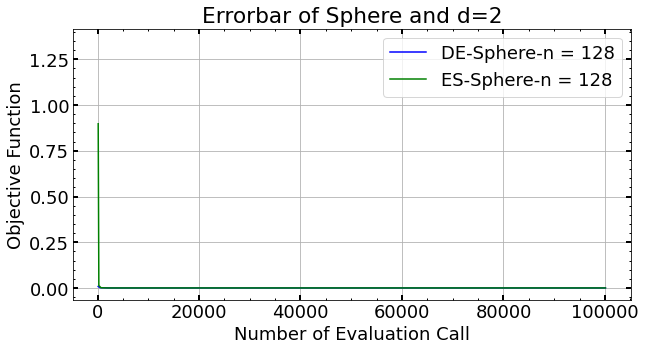

DE_Sphere_2_1024
ES_Sphere_2_1024


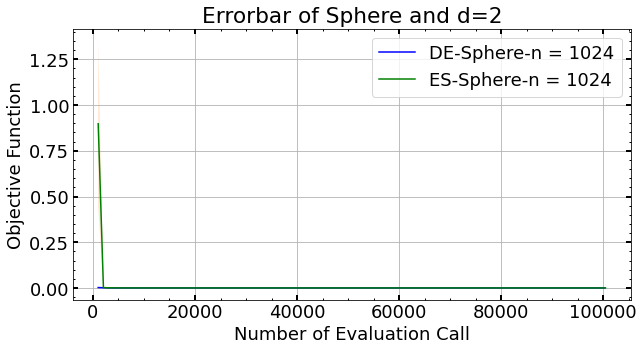

DE_RosenBrock_2_128
ES_RosenBrock_2_128


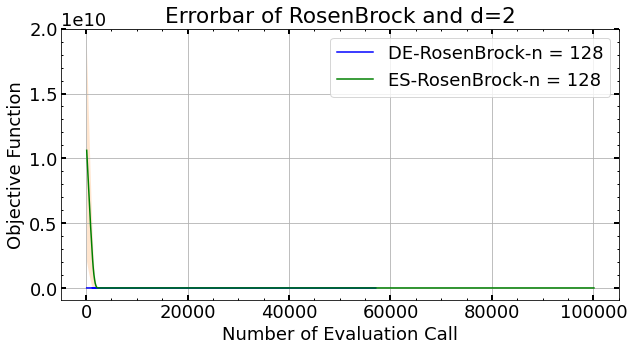

DE_RosenBrock_2_1024
ES_RosenBrock_2_1024


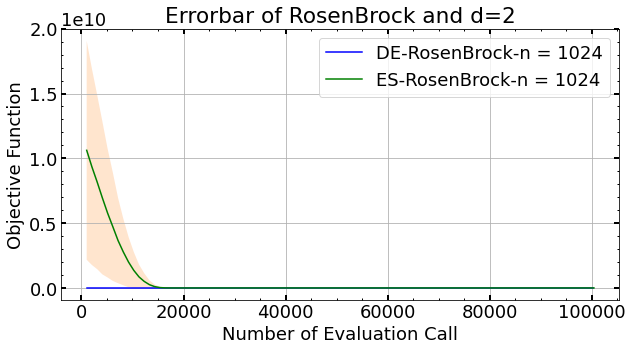

DE_Rastrigin_2_128
ES_Rastrigin_2_128


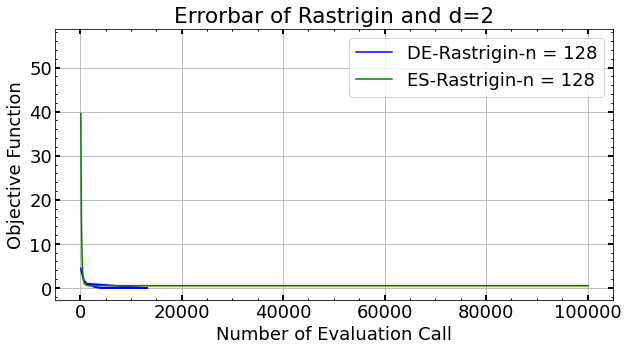

DE_Rastrigin_2_1024
ES_Rastrigin_2_1024


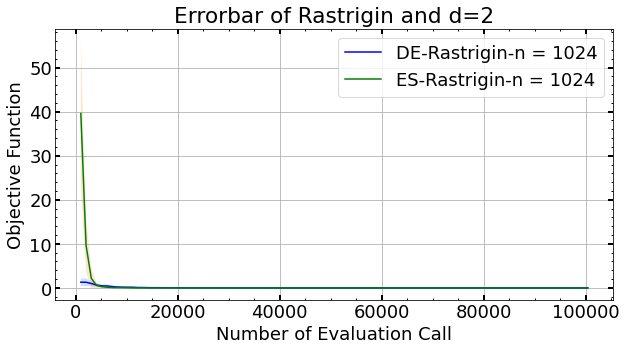

DE_Griewank_2_128
ES_Griewank_2_128


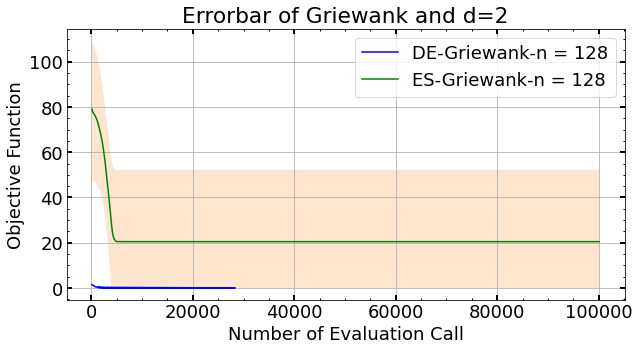

DE_Griewank_2_1024
ES_Griewank_2_1024


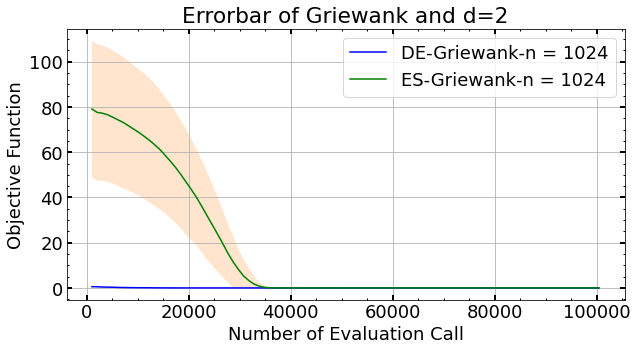

DE_Ackley_2_128
ES_Ackley_2_128


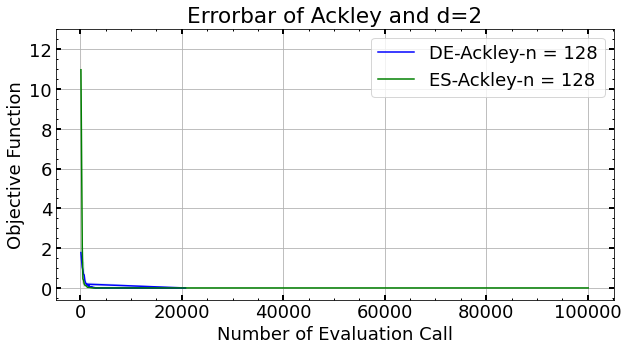

DE_Ackley_2_1024
ES_Ackley_2_1024


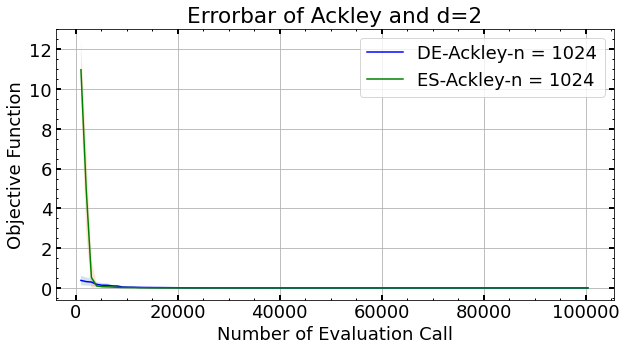

DE_Sphere_10_128
ES_Sphere_10_128


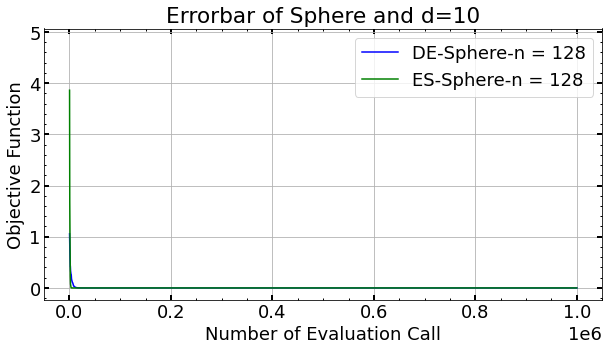

DE_Sphere_10_1024
ES_Sphere_10_1024


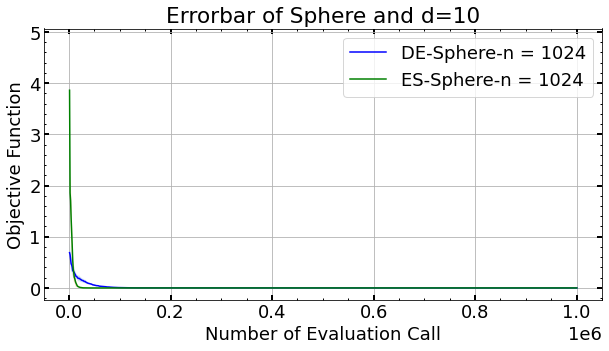

DE_RosenBrock_10_128
ES_RosenBrock_10_128


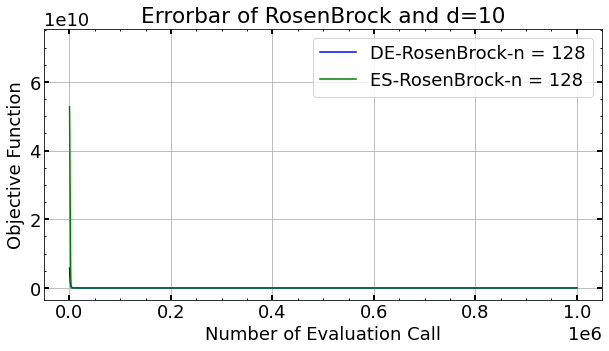

DE_RosenBrock_10_1024
ES_RosenBrock_10_1024


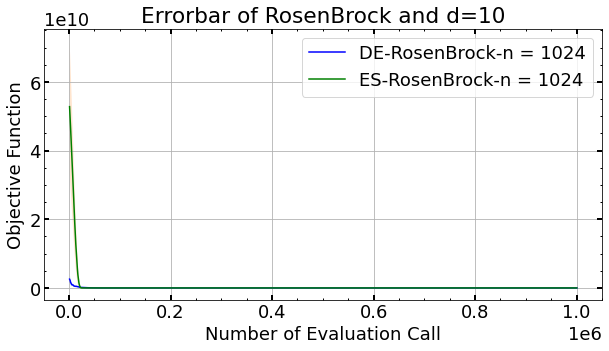

DE_Rastrigin_10_128
ES_Rastrigin_10_128


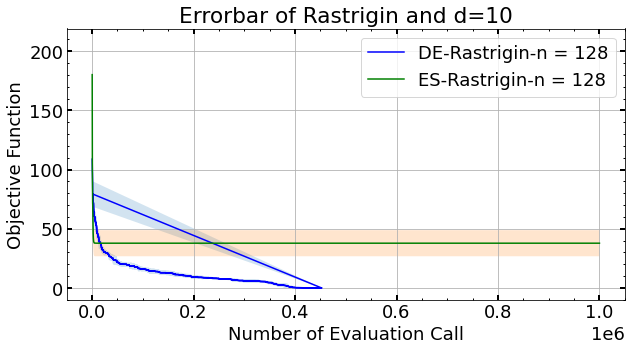

DE_Rastrigin_10_1024
ES_Rastrigin_10_1024


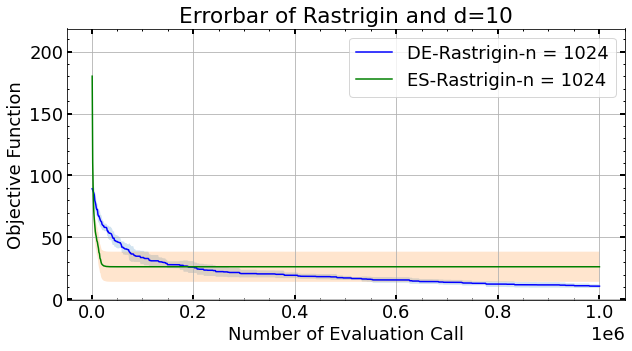

DE_Griewank_10_128
ES_Griewank_10_128


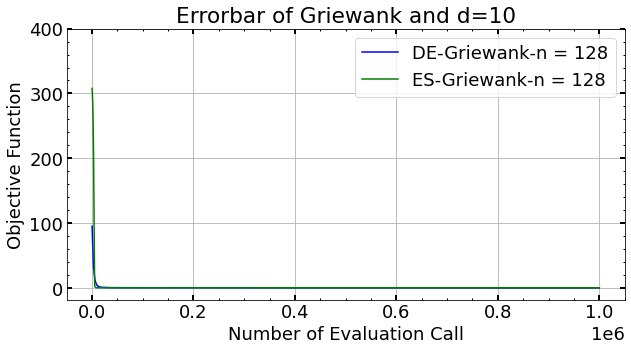

DE_Griewank_10_1024
ES_Griewank_10_1024


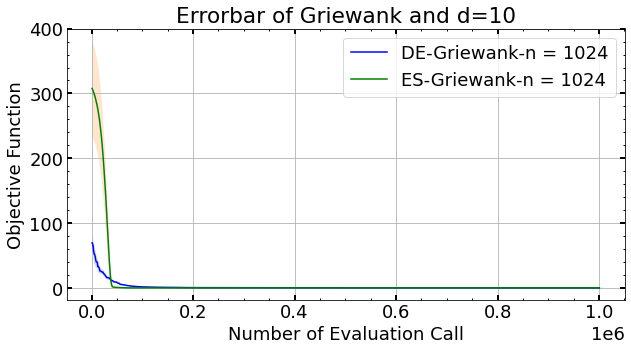

DE_Ackley_10_128
ES_Ackley_10_128


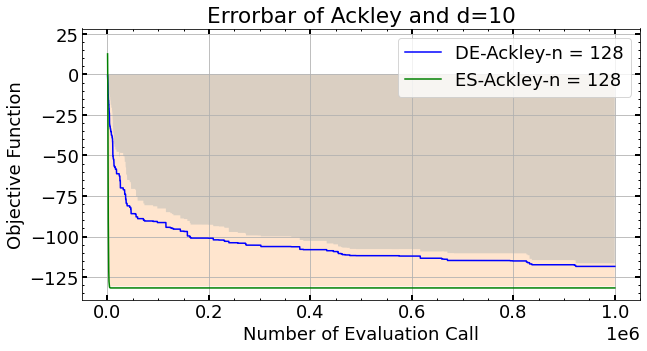

DE_Ackley_10_1024
ES_Ackley_10_1024


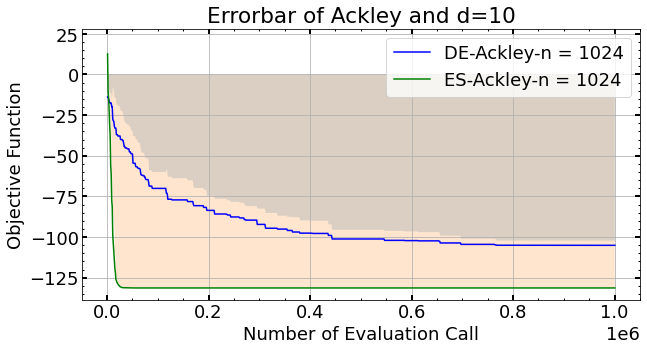

In [22]:
# For drawing graph
# So we keep all data of fitness in data['Fm']
# Need to run through this to get the 
mean = []
std = []
data = []
number_of_evaluations = []

for d in dims:
    for f in functions:
        data_call = []
        for n in Ns:
            print(f'DE_{f}_{d}_{n}')

            dataF = []
            dataEva = []

            for seed in seeds:
                # Read data from one seed run
                dataSeed = np.load(f'./logs/{f}_{d}_{n}_{seed}_DE.npz')
                
                dataF.append(getBestFitness(dataSeed['Fm']))
                dataEva.append(dataSeed['evaluations'])

            meanF ,stdF , full_dataF = calMean10Array(dataF)
            meanE, stdE, fulldataE = calMean10Array(dataEva)
            
            print(f'ES_{f}_{d}_{n}')

            dF = []
            dE = []

            for seed in seeds:
                # Read data from one seed run
                dataSeed = np.load(f'./logs/{f}_{d}_{n}_{seed}_OneLambdaES.npz')
                dF.append(dataSeed['Fm'])
                dE.append(dataSeed['evaluations'])

            temp = dE[-1] + 1
            dE.append(temp)

            mF, sF, fF = calMean10Array(dF)
            mE, sE, fE = calMean10Array(dE)

            plotGraph([meanF, mF], [meanE, mE], [stdF, sF], [stdE, sE], f, d, n)



In [ ]:
data = np.load('./logs/Ackley_2_32_19520208_DE.npz')
Fm_history = data['Fm']
getBestFitness(Fm_history)
#DE need to go through filter before getting into drawing stage

In [ ]:
# Convergence graphs
functions = ['Sphere','RosenBrock','Rastrigin', 'Griewank', 'Ackley']
#dic = {'Sphere': Sphere, 'Ackley': Ackley, 'RosenBrock': RosenBrock, 'Griewank': Griewank, 'Rastrigin': Rastrigin}

dims = [2, 10]
Ns = [128, 1024]
repeat = np.arange(19520208, 19520208+11)
als = ['DE', 'OneLambdaES']

for f in functions:
    for d in dims:
        for n in Ns:
            i = 0
            for al in als:

                for seed in repeat:
                    if al == 'OneLambdaES':

                    filename = f'./logs/{f}_{d}_{n}_{seed}_{al}.npz'
                    data = np.load(filename)




IndentationError: ignored

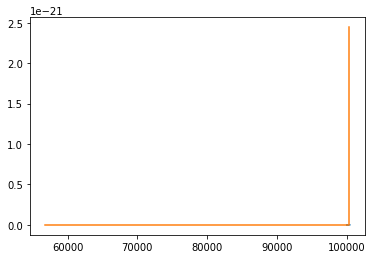

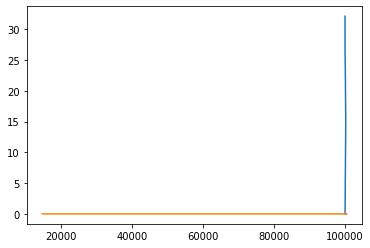

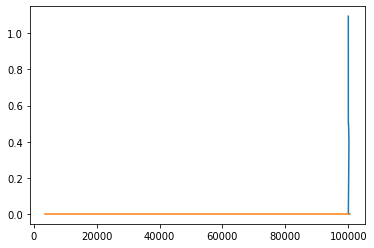

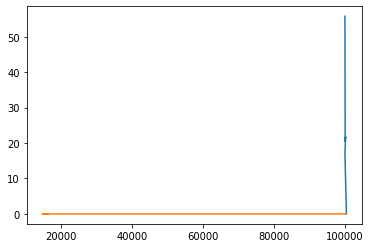

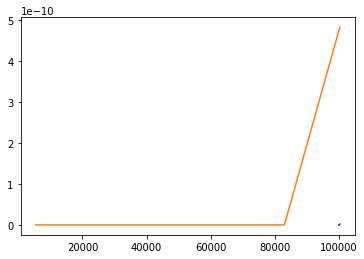

In [ ]:
#Convergence graph
listDF = []
names = ['Sphere','RosenBrock','Rastrigin', 'Griewank', 'Ackley']
#dic = {'Sphere': Sphere, 'Ackley': Ackley, 'RosenBrock': RosenBrock, 'Griewank': Griewank, 'Rastrigin': Rastrigin}
d = [2, 10]
popsize = [128, 1024]
for name in names:
    for dim in d:
        data = pd.read_pickle(f'./tables/{name}_{dim}')   
        fig = plt.figure(figsize=(10,5))
        plt.rcParams["font.size"] = 18
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = 'Ubuntu'
        plt.rcParams['font.monospace'] = 'Ubuntu Mono'
        plt.rcParams['font.size'] = 10
        plt.rcParams['axes.labelsize'] = 10
        plt.rcParams['axes.labelweight'] = 'bold'
        plt.rcParams['xtick.labelsize'] = 8
        plt.rcParams['ytick.labelsize'] = 8
        plt.rcParams['legend.fontsize'] = 10
        plt.rcParams['figure.titlesize'] = 12

        xES = data['ES', 'mean(eva)']
        yES = data['ES', 'mean(F)']
        x1_err = data['ES', 'std(F)']

        xDE = data['DE', 'mean(eva)']
        yDE = data['DE', 'mean(F)']
        x2_err = data['DE', 'std(F)']

        ax = plt.subplot(111)
        ax.plot(yES[0:len(xES)], xES, 'go-', label='ES')
        ax.fill_between(yES[0:len(xES)], xES + x1_err, xES - x1_err, alpha = 0.2, color='green')

        ax.plot(yDE[0:len(xDE)], xDE, 'go-', label='DE')
        ax.fill_between(yDE[0:len(xDE)], xDE + x2_err, xDE - x2_err, alpha = 0.2, color='green')


        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.set_yscale('log', basey=2)
        ax.minorticks_on() 
        ax.tick_params(axis="both", which="major",direction="in",length=5,width=2,top="on",right="on")
        ax.tick_params(axis="both", which="minor",direction="in",length=2,width=1,top="on",right="on")

        ax.set_title(f'{name}_{dim}')

        plt.show()
        break

# Table


In [ ]:
listDF = []
names = ['Sphere','RosenBrock','Rastrigin', 'Griewank', 'Ackley']
#dic = {'Sphere': Sphere, 'Ackley': Ackley, 'RosenBrock': RosenBrock, 'Griewank': Griewank, 'Rastrigin': Rastrigin}
d = [2, 10]
popsize = [32, 64, 128, 256, 512, 1024]
for name in names:
    for dim in d:
        data = pd.read_pickle(f'./tables/{name}_{dim}')
        df = pd.DataFrame()
        df['popsize'] = popsize
        df.set_index('popsize')

        es = []
        mean = data['ES', 'mean(F)'].to_list()
        std = data['ES', 'std(F)'].to_list()
        for i in range(len(mean)):
            es.append(f'{mean[i]}({std[i]})')

        de = []
        mean = data['DE', 'mean(F)'].to_list()
        std = data['DE', 'std(F)'].to_list()
        for i in range(len(mean)):
            de.append(f'{mean[i]}({std[i]})')

        df['ES'] = es
        df['DE'] = de
        listDF.append(df)

In [ ]:
#Sphere_2
listDF[0]

,popsize,ES,DE
0,32,0.0(0.0),0.0(0.0)
1,64,0.0(0.0),1.7051532519370927e-281(0.0)
2,128,7.862176011701614e-182(0.0),1.472987267746484e-142(3.0520923959806828e-142)
3,256,3.942998490859475e-91(7.638571750642621e-91),1.9336289568093317e-73(3.236695018438914e-73)
4,512,1.556164296333518e-45(4.505074294509793e-45),9.707758426568426e-39(9.447364210224817e-39)
5,1024,9.965557173649233e-25(2.1536767234305612e-24),2.4452870854001705e-21(2.5653137288192053e-21)


In [ ]:
#Sphere_10
listDF[1]

,popsize,ES,DE
0,32,0.0(0.0),0.0(0.0)
1,64,0.0(0.0),2.8387824520874596e-302(0.0)
2,128,0.0(0.0),1.2082822703029153e-147(3.146628012211676e-147)
3,256,0.0(0.0),7.454570154667991e-74(5.05384268724915e-74)
4,512,2.0125172392044537e-238(0.0),2.4420585236823556e-37(1.0404803178726932e-37)
5,1024,1.852074257799414e-121(5.385097949558578e-121),3.2542898903032064e-19(9.782663873977134e-20)


In [ ]:
#RosenBrock_2
listDF[2]

,popsize,ES,DE
0,32,32.123215434795405(46.52699894293605),0.0(0.0)
1,64,26.456912248106157(41.5343649389084),0.0(0.0)
2,128,23.61070790764976(37.30021341189613),0.0(0.0)
3,256,14.811990350923642(24.62669472947232),7.321659688859834e-22(1.2506166170591516e-21)
4,512,1.375099873556095e-08(3.977344925286772e-08),7.727226414556801e-05(0.00021391366157365064)
5,1024,2.9250229695005026e-13(8.637224283221165e-13),0.02936125675386341(0.03605764334305118)


In [ ]:
#RosenBrock_10
listDF[3]

,popsize,ES,DE
0,32,205.06854468457283(297.3925838613379),0.0(0.0)
1,64,85.28803444357936(137.76588382669868),0.0(0.0)
2,128,52.91465625254765(109.58404985731187),8.22146785951793e-23(4.124711922006536e-23)
3,256,209.7344070737234(411.5023428460365),7.618741204430233e-10(3.7304742078936957e-10)
4,512,243.64828448971102(402.804850033217),0.0014350271165089665(0.0004293290961393823)
5,1024,69.97495359229495(91.32170370129354),2.4332852863308814(0.13201156813157094)


In [ ]:
#Rastrigin_2
listDF[4]

,popsize,ES,DE
0,32,1.0944544590207115(1.0387663526341115),0.0(0.0)
1,64,0.4974795285466449(0.49747952854664484),0.0(0.0)
2,128,0.4974795285466449(0.49747952854664484),0.0(0.0)
3,256,0.3979836228373159(0.4874284009678471),0.0(0.0)
4,512,0.0(0.0),0.0(0.0)
5,1024,0.0(0.0),2.0605739337042905e-14(1.7606555066669026e-14)


In [ ]:
#Rastrigin_10
listDF[5]

,popsize,ES,DE
0,32,51.04111208616139(17.48992117200689),0.0(0.0)
1,64,32.63453627174981(12.81753189808547),0.0(0.0)
2,128,37.80829911417344(11.034552306101679),0.0(0.0)
3,256,35.32091303955649(12.048732901191249),4.899634393495944e-06(1.4672547891939848e-05)
4,512,31.34107928896965(14.268090503317516),7.427152175821748(0.4722088307057509)
5,1024,26.266844351584304(12.171011540363558),10.587394624262378(1.3827386898779637)


In [ ]:
#Griewank_2
listDF[6]

,popsize,ES,DE
0,32,55.800999731330855(33.22540610361499),0.0007396040334114895(0.0022188121002344684)
1,64,55.248990982536874(32.92104839018164),0.0(0.0)
2,128,20.468669344534014(31.74519830821697),0.0(0.0)
3,256,21.793348458139263(33.44566074887296),0.0(0.0)
4,512,17.14769771600719(35.785204936460985),4.2342348516299923e-10(5.523521229981533e-10)
5,1024,0.0017260712395128941(0.0034959969716279425),0.0005457425669217253(0.00030641312685567474)


In [ ]:
#Griewank_10
listDF[7]

,popsize,ES,DE
0,32,0.1993686946766866(0.1485819514495363),0.002464936527605055(0.0038185044747397136)
1,64,0.15940222690417633(0.09090459622712797),0.0(0.0)
2,128,0.2206156345982695(0.1149616241309896),0.05113344640547528(0.03470085327685971)
3,256,0.22795511225702964(0.07760697083875959),0.14534922119425925(0.015729692256748848)
4,512,0.23596866968470467(0.07411469258008237),0.2115216523506184(0.024710133652874815)
5,1024,0.2242563997885724(0.08418617628018102),0.23026823377623376(0.02502065117228248)


In [ ]:
#Ackley_2
listDF[8]

,popsize,ES,DE
0,32,0.0(0.0),0.0(0.0)
1,64,0.0(0.0),0.0(0.0)
2,128,0.0(0.0),0.0(0.0)
3,256,0.0(0.0),0.0(0.0)
4,512,0.0(0.0),0.0(0.0)
5,1024,2.354738626308972e-12(3.486216150069866e-12),4.826443245065093e-10(3.151782651421847e-10)


In [ ]:
#Ackley_10
listDF[9]

,popsize,ES,DE
0,32,-131.91044732464417(1.0357542047201092),-140.18818128173643(3.2267380083531556)
1,64,-131.7684676516896(1.2713211526381414),-137.5993138213667(7.555976832899765)
2,128,-131.7079731431166(0.9553665700490955),-118.42250106129461(1.9383097834085874)
3,256,-131.25796153113362(0.7474643513140182),-113.98359671744713(4.050242712580401)
4,512,-131.2290757953816(1.2166151140797878),-110.94493472543714(4.82012646535061)
5,1024,-131.27511722156342(0.6058968475283617),-105.06108523142439(2.8746209955112696)
